***Creation of a quantum digraph includes three stages:***<br/>
- *Converting an undirected graph to an adjacency matrix*
- *Changing all undirected edges to weighted directed edges*
- *Expanding a digraph to a QGraph (quantum digraph) by adding loops to stop vertices*

Note that on measurement, probabilities of navigation from a vertex to all possible targets adds to 1.

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class QGraph(object):

    def __init__(self, g, method='rand'):
        self.g = g
        self.qgraph = self.__digraph_expanded_and_weighed(g, method=method)
        self.adj = self.__digraph_to_adjmat(self.qgraph)
        self.n_vertices = self.qgraph.number_of_nodes()
        self.n_qubits =  int(np.ceil(np.log2(self.n_vertices)))

    def __digraph_expanded_and_weighed(self, g, method='rand'):
        g_adj = nx.adjacency_matrix(g).toarray() # todense()
        g_adj_expanded = self.__digraph_adj_expand(g_adj)
        g_adj_weighed = self.__digraph_adj_weigh(g_adj_expanded, method=method)
        return nx.DiGraph(g_adj_weighed)
    
    def __digraph_adj_expand(self, w_adj):
        exp_adj = w_adj.copy() #.toarray()
        for r in range(w_adj.shape[0]):
            r_sum = np.count_nonzero(w_adj[r])
            if r_sum == 0:
                # No outgoing links - create a loop
                exp_adj[r, r] = 1.0
        return exp_adj

    def __digraph_adj_weigh(self, unw_adj, method='rand'):
        w_adj = unw_adj.copy().astype(float)
        for r in range(unw_adj.shape[0]):
            r_sum = sum(unw_adj[r])
            r_nz = np.count_nonzero(unw_adj[r])
            if r_sum != 0.0:
                # Edges available - generate weights
                if method == 'rand':
                    nz_weights = np.random.random(r_nz)
                else:
                    nz_weights = np.array([num*1.0 for num in unw_adj[r] if num])
                nz_weights /= nz_weights.sum()
                w_no = 0
                for c in range(unw_adj.shape[1]):
                    if unw_adj[r, c] > 0:
                        w_adj[r, c] = nz_weights[w_no]
                        w_no += 1
        return np.around(w_adj, 3)

    def __digraph_to_adjmat(self, G):
        adj_comp = nx.adjacency_matrix(G, nodelist=None, dtype=None, weight='weight')
        return adj_comp.todense()

In [3]:
# graph for train Qgraph
g = nx.gnp_random_graph(16, 0.1, directed=True)
G_ob = QGraph(g, method='scale')
G = G_ob.qgraph
G_adj = G_ob.adj
n_data = G_ob.n_qubits


/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_57316/1234351715.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  g_adj = nx.adjacency_matrix(g).toarray() # todense()
/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_57316/1234351715.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_comp = nx.adjacency_matrix(G, nodelist=None, dtype=None, weight='weight')


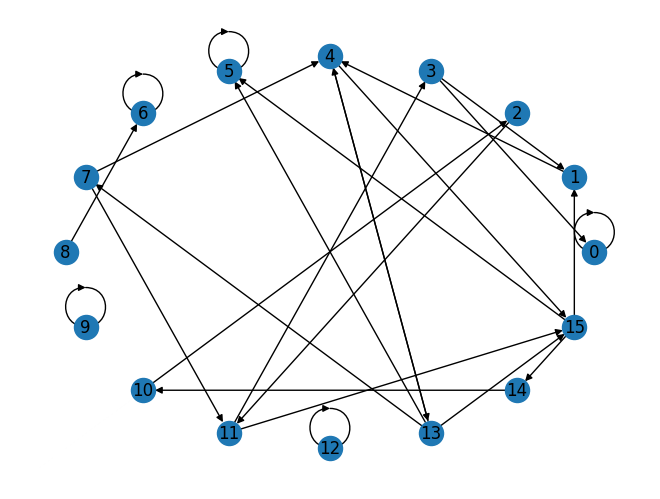

In [4]:
nx.draw_circular(G, with_labels=True)
plt.show()

In [5]:
import torch
import numpy as numpy_np
dtype = torch.float32
torch.set_default_dtype(dtype)
torch_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch_device = "cpu"
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def bin_int_to_list(a, n_bits):
    a = int(a)
    a_list = [int(i) for i in f'{a:0{n_bits}b}']
    # a_list.reverse()
    return numpy_np.array(a_list)

def nums_to_bin_tensor(num_list, n_data, torch_device='cpu'):
    bin_list_list = np.array([bin_int_to_list(n, n_data) for n in num_list])
    tens_list = torch.tensor(bin_list_list, dtype=dtype)
    return tens_list.to(torch_device)

X = nums_to_bin_tensor(range(G_adj.shape[0]), n_data, torch_device=torch_device)
Y = torch.tensor(G_adj, dtype=dtype)

In [6]:
X

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [7]:
Y

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

In [8]:
import copy

def train_model(model, lossfun, optimizer, X, Y, epochs=50, log_interv=100, prompt_fract=0.1, info_level=1):

    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    loss = 0
    running_loss = 0

    ## Optional for simple gradient optimisers, such as Adam
    ## Required by optimisers with internal steps, such as LBFGS
    ## Works for both types of optimisers
    def closure():
        nonlocal X, Y, model, lossfun, loss
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        output = model(X)
        loss = lossfun(output, Y)
        if loss.requires_grad:
            loss.backward()
        return loss
      
    ## This loop does not collect losses from the intermediate / internal steps
    ## If all losses are required the loss collection must happen within a closure
    model.train()
    for epoch in range(epochs):

        optimizer.step(closure)
        
        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            if info_level > 0: print(f'epoch {epoch} \t Loss: {loss.item():.5g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)

In [9]:

import pennylane as qml
def qgraph_basis(wires, n_data, n_extra, n_layers=1, rot='Ry', scaler=np.pi):
    
    def _qgraph_circ(inputs, weights):
        # inputs: A single number, being a scaled (down) vertex id
        #         Note that when a NN generates inputs, its results will be in range [-1..1]
        # output: probability distribution of applying the circuit shot number of times
        nonlocal wires, n_data, n_extra, n_layers, rot, scaler
        
        n_learn = n_data + n_extra
        data_wires = wires[0:n_data]
        learn_wires = wires[0:n_learn]
        scaled_inputs = torch.mul(inputs, scaler)
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)
        
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=learn_wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=learn_wires)
        # return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
        return qml.probs(wires=data_wires)
    return _qgraph_circ

def qgraph_basis_shape(n_data, n_extra, n_layers=1, rot='Ry'):
    n_wires = n_data + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        shape = (0)
    return shape


class qgraph_model(torch.nn.Module):

    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi, seed=0, ws=0.1):
        super(qgraph_model, self).__init__()

        self.qg_mode = 'q'
        self.sim = sim
        self.n_data = n_data
        self.n_extra = n_extra
        self.n_wires = n_data+n_extra
        self.wires = list(range(self.n_wires))
        self.n_layers = n_layers
        self.rot = rot
        self.shots = shots
        self.scaler = scaler
        self.seed = 123 if seed == 0 else seed
        self.wscaler = ws
        self.mode('quantum')

        # Create the model
        def_qlayer = self.qlayer()
        layers = self.layers(def_qlayer)        
        self.model = torch.nn.Sequential(*layers)  

    ### Define an optional (default) quantum layer
    def qlayer(self):
        # Define QGraph circuit weight shapes
        tensor_shape = qgraph_basis_shape(self.n_data, self.n_extra, n_layers=self.n_layers, rot=self.rot)
        weights_shapes = {"weights": tensor_shape}
        torch.manual_seed(self.seed)
        weights = torch.rand(tensor_shape, requires_grad=True) * self.wscaler
        init_method = {"weights": weights} # torch.nn.init.normal_ # torch.nn.init.uniform_

        # Define QGraph circuit and its layer
        qgraph = qgraph_basis(self.wires, self.n_data, self.n_extra, n_layers=self.n_layers, rot=self.rot, scaler=self.scaler)
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)
        qgraph_node = qml.QNode(qgraph, dev, interface='torch') #, diff_method='spsa') #, level='gradient')
        qlayer = qml.qnn.TorchLayer(qgraph_node, weight_shapes=weights_shapes, init_method=init_method)
        return qlayer
        
    ### Define all qgraph layers and return their list
    def layers(self, qlayer):
        ### Default only a quantum layer
        return [qlayer]

    ### Set or return the qgraph mode (any string)
    def mode(self, vmode=None):
        if vmode is not None:
            self.qg_mode = vmode
        return self.qg_mode

    ### Apply the model to data
    def forward(self, x):
        x = self.model(x)
        return x


    def get_weights(self):
        return {k:v for k, v in self.state_dict().items() if "weight" in k}

    def get_biases(self):
        return {k:v for k, v in self.state_dict().items() if "bias" in k}





In [10]:
import time
sim = 'default.qubit' 
n_extra = 3
n_layers = 20
rot = 'Rxyz'
### Train the model
qgraph = qgraph_model(sim, n_data, n_extra, n_layers=n_layers, rot=rot).to(torch_device)
lossfun = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(qgraph.parameters(), max_iter=20, lr=1, tolerance_change=1e-10, tolerance_grad=1e-08, line_search_fn='strong_wolfe')
epochs = 100
log_interv = 1
info_level =0




start = time.time()

hist_loss, opt_params, hist_params, opt_point = \
    train_model(qgraph, lossfun, optimizer, X, Y, epochs=epochs, log_interv=log_interv, prompt_fract=0.05, info_level=0)

elapsed = time.time() - start

In [11]:
qgraph.get_biases()

{}

In [14]:
qgraph.get_weights()

{'model.0.weights': tensor([[[ 2.9598e-02,  4.3369e-01, -4.1827e-01],
          [ 6.8856e-02,  6.8925e-01,  4.9206e-01],
          [ 1.3654e-02,  3.3555e-01, -6.3739e-02],
          [ 7.2672e-02, -1.8856e-01,  3.7005e+00],
          [ 7.5561e-03, -5.6591e-01,  1.5227e+00],
          [ 4.0181e-02,  4.6890e-01, -4.6957e-01],
          [ 3.8189e-02, -1.5612e-01, -1.0957e+00]],
 
         [[ 5.1777e-01,  3.2140e-01,  4.7384e-02],
          [-2.3197e-01,  5.1125e-01, -2.0988e-01],
          [ 1.0069e+00,  9.4381e-01,  1.5030e-01],
          [ 2.1063e-01, -5.4714e-01,  4.3996e-02],
          [-2.9070e-02,  5.7817e-01, -2.5819e-02],
          [ 4.8448e-01,  2.4963e-01,  3.2953e-02],
          [-9.0153e-01,  8.2314e-01,  9.7539e-02]],
 
         [[-1.3052e+00,  5.0076e-01,  3.4202e-01],
          [ 1.2372e+00, -3.4934e-01, -8.7493e-01],
          [-1.7965e-01,  2.8898e-01,  3.7735e-01],
          [ 1.9692e-01,  3.8533e-01, -3.6744e-01],
          [ 8.2891e-01,  2.8263e-01, -6.7209e-01],
      

In [16]:
len(qgraph.get_weights()['model.0.weights'])

20

In [ ]:
dev = qml.device('default.qubit', 4)
@qml.qnode(device=dev)
def cir():
    qgraph.prepare_circ_(qgraph.get_ansatz_weigths())
    return qml.state()

In [ ]:
cir()